# B455 Project 2
### By: Owen Gordon




For this project, we used the Wisconsin Breast cancer dataset to futher learn how to implement the multi layer perceptron algorithm. This dataset has 569 instances which 32 attributes each. The first attribute is the ID number, which can be ignorned. The second attribute is the diagnosis, either malignant or benign. This value will require preprocessing to turn the character into a binary value. The 30 remaining attributes are the continuous features for each input. The class distribution is 357 benign diagnoses and 212 malignant diagnoses.
<br><br>
The libararies 
that I used for this project were pandas, numpy, matplotlib and sklearn. I used pandas to read the csv file with the data, as well as format the data for some preprocessing. I used numpy for all of the mathematical operations. I used matplotlib to visualize the results. Finally, I used sklearn to implement the MLP classifier, and also to plot the classifier learning curve.

The first step is to prepare the data to be inputted into the classifer. This includes importing the csv file, separating the data into the inputs and targets, doing some preprocessing to convert the targets to binary values, and finally normalizing the input data. <br><br>

To import the csv file, I used the read_csv method from the pandas libaray. This created a dataframe to contain all of the inputs and targets, which made manipulation easier. The data was then separated into the inputs and targets by slicing the dataframe. Since the inputs are simply values, this dataframe slice was easily convered into a numpy array using the to_numpy function in the pandas library. Before coverting the target dataframe slice into a numpy array, each member was iterated over, and if the value was 'B', then it was assigned the binary value 0. Likewise, if the value was 'M', it was assigned the value 1. Finally, this array was converted into a numpy array. <br> <br>

To normalize the input values, the following formula was used:  $z = \frac{x - \mu}{\sigma}$, 
where $x$ is the current value, $\mu$ is the mean of this feature, $\sigma$ is the standard deviation of this feature, and $z$ is the normalized value. This normalization type is standardization which places the mean of the data at 0, and a unit standard deviation. Instead of mapping the values between 0 and 1, this method allows for unbounded values, but centers the data around 0.<br><br>

One final note, to import the data correctly, the 'wdbc.csv' file must be in the same directory as this .ipynb file. If this is not the case, the path to the .csv file must be changed in the read_csv argument.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import learning_curve
from sklearn.metrics import confusion_matrix

# Load the data from the csv
df = pd.read_csv('./wdbc.csv', header=None)

# Gather the inputs
INPUTS = df[df.columns[2:]].to_numpy()

# Gather the targets, convert from letters to binary values
targets = df[df.columns[1:2]].to_numpy()
TARGETS = list()
for t in targets:
  if t == 'B':
    TARGETS.append(0)
  elif t == 'M':
    TARGETS.append(1)
TARGETS = np.array(TARGETS)

# normalize the data
def normalize_data(inputs):
    return (inputs - inputs.mean(axis=0)) / (inputs.std(axis=0))

INPUTS = normalize_data(INPUTS)

Unlike the last project, in this project we are allowed to, and ecouraged to, use the sklearn implementation of an MLP classifer. The MLPClassifer class is found inside of the neural_network module of the sklearn package. Since I didn't implement any of the MLP algorithms, the next step is implementing the 5-fold cross-validation algorithm. This splits the inputs and targets into 5 groups, where 4/5ths of the data is used for training and 1/5 of the data is used for testing, and there are 5 iterations of training/testing. This way each of the 5 groups is used for validation, and thus the average accuracy of the 5 groups is used for the model accuracy. <br><br>

The arguments for the 5-fold function are the input values, target values, and the hidden layer sizes. The user can also specifcy the number of epochs, as well as the learning rate for the classifer. The four final arguments are used for model evaluation. The plot_loss argument will plot the loss graph for each classifer which is helpful to identify overfitting in the MLP. The next 2 arguments, verbose and light_verbose, prints out the individual statistics for each network, which can also be used to identify overfitting. The final argument, conf_matrix will display the confusion matrix if the user wants this. <br><br>

The 5-fold cross validation function has 2 major sections. The first section is short, it splits the data into 5 groups. The second section is much longer, this is the learning phase. To begin each round of training, the ith group is used for validation, with the other 4 groups used for training data. Next, an MLP classifer is instantiated with the hidden layer sizes and learning rate specified. These are two independent variables can be changed for testing. <br><br>

An important part of this project was identifying overfitting in our models. Overfitting is when the learning process goes on too long and the weights inside of the model start to become too specific for the training data, so the prediction using the testing data becomes less accurate. To spot overfitting the loss value at each learning iteration can be calculated and recorded, and after the model is done training this value can be plotted against the epoch number to reveal if overfitting occured or not. The error function that sklearn uses for backpropogation is cross-entropy, so the loss function best used to evalue the models is the log-loss function. The equation for the log-loss function is $L = - y  \cdot \ln(\hat y)$. This equation is the inner product of the target vector $y$ and the prediction vector $\hat y$. I slightly modified this equation by dividing the inner product by $N$, the number of values in the vectors. This way the recorded loss value is the average loss of the entire vector, instead of the sum of the loss values. This small change turns this loss function into the cost function, but it achieves the same goal to identify overfitting. <br><br>

After training has completed, the accuracy of the network is recording using the validation group. The mean accuracy is returned by this method, showing the accuracy of the network using the given hidden layer sizes, learning rate, and number of epochs. If the loss plots were created then overfitting can be identified after this method is executed, and the parameters can be adjusted to minimize overfitting. To quantify overfitting, if the final testing loss is 3% greater than the minimum testing loss, overfitting is said to have occured.

In [2]:
def five_fold_cross_validation(hidden_layer_sizes, inputs, targets, epochs=200, 
                               learning_rate=1e-3, plot_loss=False, verbose=False, 
                               light_verbose=False, show_conf_matrix=False):
  
  # caluclate the log loss for the classifer at each learning step
  def calculate_log_loss(mlp, inputs, targets):
    probabilities = mlp.predict_proba(inputs)
    prediction_probabilities = [np.log(y_hat[y]) if y == 1 else np.log(1 - y_hat[y]) for y, y_hat in zip(targets, probabilities)]
    return (-1 / len(targets)) * np.inner(targets, prediction_probabilities)

  # split the data up into 5 classes
  def five_fold(inputs, targets):
    D_inputs = []
    t_targets = []
    D_dict = {'d1': [], 'd2': [], 'd3': [], 'd4': [], 'd5': []}
    t_target_dict = {'d1': [], 'd2': [], 'd3': [], 'd4': [], 'd5': []}

    for x in range(len(inputs)):
      D_dict['d' + str((x % 5) + 1)].append(inputs[x])
      t_target_dict['d' + str((x % 5) + 1)].append(targets[x])
    for k in D_dict.keys():
      D_inputs.append(np.array(D_dict[k]))
      t_targets.append(np.array(t_target_dict[k]))
    return D_inputs, t_targets

  D, t = five_fold(inputs, targets)

  accuracies = [] # accuracies of each network
  overfitted = 0 # number of models that overfit

  for i in range(len(D)): # loop over the 5 classes
    testing_inputs = D[i] # use the ith group for validation
    training_inputs = []
    testing_targets = t[i]
    training_targets = []
    for j in range(len(D)): # the other 4 groups are used for training
      if i != j:
        training_inputs.extend(D[j])
        training_targets.extend(t[j])
    training_inputs = np.array(training_inputs)
    training_targets = np.array(training_targets)

    # create an MLP classifer
    mlp = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, learning_rate_init=learning_rate)

    training_loss = []
    testing_loss = []

    min_training_loss = np.inf
    min_testing_loss = np.inf

    # train the model for the number of epochs specified by the user (default is 200)
    for epoch in range(epochs):
      mlp._partial_fit(training_inputs, training_targets, [0, 1])    

      # calculate training loss
      loss = calculate_log_loss(mlp, training_inputs, training_targets)
      if loss < min_training_loss:
        min_training_loss = loss
      training_loss.append(loss)

      # calculate testing loss
      loss = calculate_log_loss(mlp, testing_inputs, testing_targets)
      if loss < min_testing_loss:
        min_testing_loss = loss
      testing_loss.append(loss)

    # plot the loss graphs
    if plot_loss:
      plt.plot(training_loss, label="Training Loss")
      plt.plot(testing_loss, label="Testing Loss")
      plt.xlabel("Number of Epochs")
      plt.ylabel("Cost")
      plt.title("MLP Loss, Learning rate="+str(learning_rate))
      plt.legend()
      plt.show()

    first_training_loss = training_loss[0]
    first_testing_loss = testing_loss[0]

    k = -1
    final_training_loss = training_loss[k]
    while np.isnan(final_training_loss):
      k -= 1
      final_training_loss = training_loss[k]

    k = -1
    final_testing_loss = testing_loss[k]
    while np.isnan(final_testing_loss):
      k -= 1
      final_testing_loss = testing_loss[k]

    # record network accuracy using the validation group
    accuracy = mlp.score(testing_inputs, testing_targets)
    accuracies.append(accuracy)

    # print model accuracy
    print(f"Accuracy of model {i + 1}: {accuracy}")

    # print out detailed report on each MLP
    if verbose:
      print(f"MLP Report:\n\tBest training loss: {min_training_loss}, Final training loss: {final_training_loss}\n\tBest testing loss: {min_testing_loss}, Final testing loss: {final_testing_loss}\n")

    # determine overfitting
    testing_loss_range = first_testing_loss - min_testing_loss
    final_testing_loss_range = first_testing_loss - final_testing_loss
    # if the final loss value is higher than the lowest loss value, then there was overfitting
    if 1 - (final_testing_loss_range / testing_loss_range) > 0.03:
      if verbose: print("Overfitting identified")
      overfitted += 1

    # generate the model confusion matrix
    if show_conf_matrix:
      prediction = mlp.predict(testing_inputs)
      conf_matrix = confusion_matrix(prediction, testing_targets)
      true_negative = conf_matrix[0][0]
      false_negative = conf_matrix[0][1]
      true_positive = conf_matrix[1][1]
      false_positive = conf_matrix[1][0]
      print(f"Confusion Matrix: [[{true_negative}, {false_negative}],")
      print(f"                   [{false_positive}, {true_positive}]]")
      print(f"Number of true benign predictions: {true_negative}")
      print(f"Number of false benign predictions: {false_negative}")
      print(f"Number of false malignant predictions: {false_positive}")
      print(f"Number of true malignant predictions: {true_positive}\n")


  if verbose or light_verbose: 
    if overfitted == 1: 
      mword = "model" 
    else: 
      mword = "models"
    print(f"{overfitted} {mword} experienced overfitting")

  # return the average accuracy of the 5 networks
  return np.mean(accuracies)

In [3]:
# run the inputs and targets through 5 fold cross validation
score = five_fold_cross_validation([100], INPUTS, TARGETS)
print("MLP 5-fold cross validation accuracy:", score)

Accuracy of model 1: 0.956140350877193
Accuracy of model 2: 0.956140350877193
Accuracy of model 3: 0.9912280701754386
Accuracy of model 4: 0.9736842105263158
Accuracy of model 5: 1.0
MLP 5-fold cross validation accuracy: 0.9754385964912281


Using a network with a single hidden layer of 100 nodes, a learning rate of 0.001 and 200 epochs, the model accuracy is between 95% and 100%. Which shows the network learning is succesful and a discriminant function is able to be created to divide the given data and accuratly predict the right diagnosis given the features.

The next task is to identify overfitting in the model. To do this, the plot_loss parameter for the 5-fold cross-validation will be turned on. The same 100 node hidden layer, 0.001 learning rate, and 200 epoch learning period will be used.

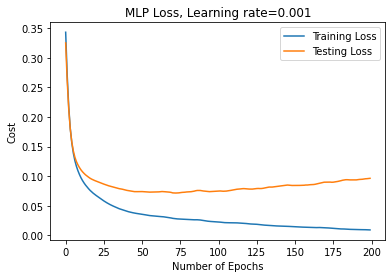

Accuracy of model 1: 0.956140350877193


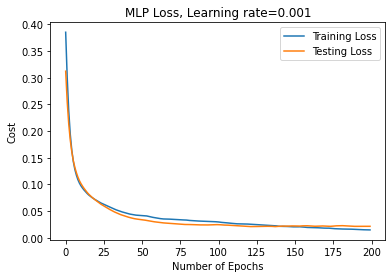

Accuracy of model 2: 0.956140350877193


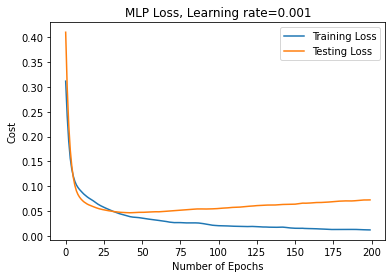

Accuracy of model 3: 0.9912280701754386


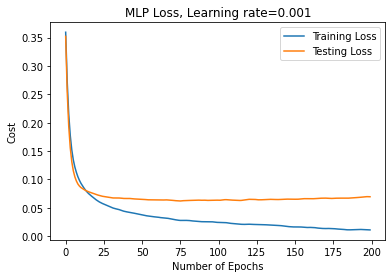

Accuracy of model 4: 0.9649122807017544


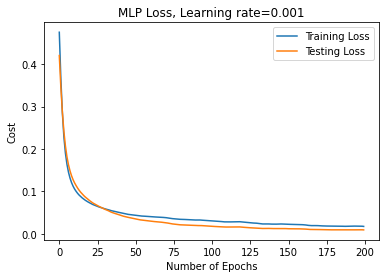

Accuracy of model 5: 1.0
MLP 5-fold cross validation accuracy: 0.9736842105263157


In [4]:
# run the inputs and targets through 5 fold cross validation, this time with plot_loss=True
score = five_fold_cross_validation([100], INPUTS, TARGETS, plot_loss=True)

print("MLP 5-fold cross validation accuracy:", score)

Again, the accuracy is between 95% and 100%, but this time it is clear some instances of the MLP were overfitting. These two graphs below show one instance of no overfitting, and one instance of overfitting.

This graph shows no overfitting, so the MLP did not overfit. Both loss curves approach 0 and seem to converge, which means the accuracy is probably higher.

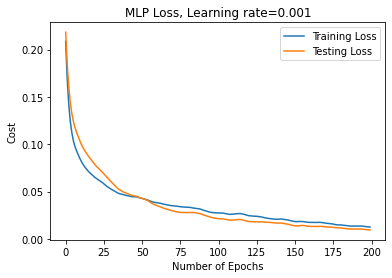

In this graph the overfitting is extremely apparent. The orange line, which is the testing loss, initially goes downwards, but near epoch 50 the loss begins to go up again, meaning the accuracy is going down because the error is going up. This is what should be avoided in an MLP because it means lower accuracy.

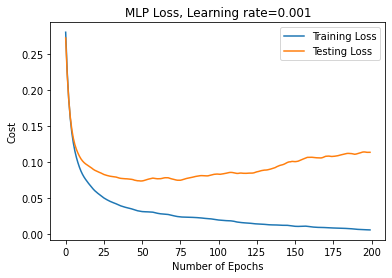

To minimize the overfitting, the 3 model paramenters of the network can be adjusted. To experiment with different values, I am going to experiment with different hidden layer sizes, different number of hidden layers, different learning rates and different number of epochs. Using the argument light_verbose from the 5-fold cross-validation method, the number of models that overfit is counted, and the paramenters can be analyzed.

In [5]:
# run the inputs and targets through 5 fold cross validation to get overfitting baseline
score = five_fold_cross_validation([100], INPUTS, TARGETS, light_verbose=True)

print("MLP 5-fold cross validation accuracy:", score)

Accuracy of model 1: 0.956140350877193
Accuracy of model 2: 0.956140350877193
Accuracy of model 3: 0.9912280701754386
Accuracy of model 4: 0.9736842105263158
Accuracy of model 5: 1.0
2 models experienced overfitting
MLP 5-fold cross validation accuracy: 0.9754385964912281


As a baseline, 2-3 models using the standard inputs experienced overfitting.<br><br>

Now, to experiment with the other parameters I am going to adjust the hidden layer width, and number of hidden layers to see if this produces less overfitting.<br><br>

Because using large layers can makes the numbers close to zero, warnings tend to pop up and make reading the output difficult. To get around this I am going to supress warnings.

In [6]:
import warnings
warnings.filterwarnings("ignore")

print("Testing hidden layer with nodes=10")
hidden_layer_10 = five_fold_cross_validation([10], INPUTS, TARGETS, light_verbose=True)
print("Hidden layer nodes=10 accuracy:", hidden_layer_10)
print()
print("Testing hidden layer with nodes=50")
hidden_layer_50 = five_fold_cross_validation([50], INPUTS, TARGETS, light_verbose=True)
print("Hidden layer nodes=50 accuracy:", hidden_layer_50)
print()
print("Testing hidden layer with nodes=200")
hidden_layer_200 = five_fold_cross_validation([200], INPUTS, TARGETS, light_verbose=True)
print("Hidden layer nodes=200 accuracy:", hidden_layer_200)
print()
print("Testing hidden layer with nodes=500")
hidden_layer_500 = five_fold_cross_validation([500], INPUTS, TARGETS, light_verbose=True)
print("Hidden layer nodes=500 accuracy:", hidden_layer_500)
print()
print("Testing hidden layer with nodes=1000")
hidden_layer_1000 = five_fold_cross_validation([1000], INPUTS, TARGETS, light_verbose=True)
print("Hidden layer nodes=1000 accuracy:", hidden_layer_1000)

Testing hidden layer with nodes=10
Accuracy of model 1: 0.9736842105263158
Accuracy of model 2: 0.9649122807017544
Accuracy of model 3: 0.9736842105263158
Accuracy of model 4: 0.956140350877193
Accuracy of model 5: 0.9911504424778761
2 models experienced overfitting
Hidden layer nodes=10 accuracy: 0.9719142990218911

Testing hidden layer with nodes=50
Accuracy of model 1: 0.956140350877193
Accuracy of model 2: 0.956140350877193
Accuracy of model 3: 0.9912280701754386
Accuracy of model 4: 0.9649122807017544
Accuracy of model 5: 1.0
3 models experienced overfitting
Hidden layer nodes=50 accuracy: 0.9736842105263157

Testing hidden layer with nodes=200
Accuracy of model 1: 0.956140350877193
Accuracy of model 2: 0.9649122807017544
Accuracy of model 3: 0.9824561403508771
Accuracy of model 4: 0.956140350877193
Accuracy of model 5: 1.0
3 models experienced overfitting
Hidden layer nodes=200 accuracy: 0.9719298245614034

Testing hidden layer with nodes=500
Accuracy of model 1: 0.94736842105263

Looking at these results, it is clear which model was the best. The structure with a single layer of size 10 had the least overfitting. Every other model had overfitting on the same level, or higher than the baseline layer size of 10. The complexity tradeoff is something that needs to be balanced, because a lower complexity could end up not seperating the data at all, which would produce very low accuracy. In this case it seems like the right balance of regularity and accuracy has been met because the accuracy is still high while keeping overfitting low.<br><br>

Next, I am going to test multiple hidden layers. Adding more layers will add complexity because more nodes are being added, so I assume that the rate of overfitting will increase.

In [7]:
print("Testing hidden layer with nodes=[2, 2]")
hidden_layer_2_2 = five_fold_cross_validation([2, 2], INPUTS, TARGETS, light_verbose=True)
print("Hidden layer nodes=[2, 2] accuracy:", hidden_layer_2_2)
print()
print("Testing hidden layer with nodes=[5, 2]")
hidden_layer_5_2 = five_fold_cross_validation([5, 2], INPUTS, TARGETS, light_verbose=True)
print("Hidden layer nodes=[5, 2] accuracy:", hidden_layer_5_2)
print()
print("Testing hidden layer with nodes=[5, 5]")
hidden_layer_5_5 = five_fold_cross_validation([5, 5], INPUTS, TARGETS, light_verbose=True)
print("Hidden layer nodes=[5, 5] accuracy:", hidden_layer_5_5)
print()
print("Testing hidden layer with nodes=[5, 5, 5]")
hidden_layer_5_5_5 = five_fold_cross_validation([5, 5, 5], INPUTS, TARGETS, light_verbose=True)
print("Hidden layer nodes=[5, 5, 5] accuracy:", hidden_layer_5_5_5)
print()
print("Testing hidden layer with nodes=[10, 5]")
hidden_layer_10_5 = five_fold_cross_validation([10, 5], INPUTS, TARGETS, light_verbose=True)
print("Hidden layer nodes=[10, 5] accuracy:", hidden_layer_10_5)
print()
print("Testing hidden layer with nodes=[10, 10]")
hidden_layer_10_10 = five_fold_cross_validation([10, 10], INPUTS, TARGETS, light_verbose=True)
print("Hidden layer nodes=[10, 10] accuracy:", hidden_layer_10_10)
print()
print("Testing hidden layer with nodes=[10, 10, 10]")
hidden_layer_10_10_10 = five_fold_cross_validation([10, 10, 10], INPUTS, TARGETS, light_verbose=True)
print("Hidden layer nodes=[10, 10, 10] accuracy:", hidden_layer_10_10_10)
print()
print("Testing hidden layer with nodes=[50, 50]")
hidden_layer_50_50 = five_fold_cross_validation([50, 50], INPUTS, TARGETS, light_verbose=True)
print("Hidden layer nodes=[50, 50] accuracy:", hidden_layer_50_50)
print()
print("Testing hidden layer with nodes=[50, 50, 50]")
hidden_layer_50_50_50 = five_fold_cross_validation([50, 50, 50], INPUTS, TARGETS, light_verbose=True)
print("Hidden layer nodes=[50, 50, 50] accuracy:", hidden_layer_50_50_50)
print()
print("Testing hidden layer with nodes=[100, 100]")
hidden_layer_100_100 = five_fold_cross_validation([100, 100], INPUTS, TARGETS, light_verbose=True)
print("Hidden layer nodes=[100, 100] accuracy:", hidden_layer_100_100)
print()
print("Testing hidden layer with nodes=[100, 100, 100]")
hidden_layer_100_100_100 = five_fold_cross_validation([100, 100, 100], INPUTS, TARGETS, light_verbose=True)
print("Hidden layer nodes=[100, 100, 100] accuracy:", hidden_layer_100_100_100)
print()
print("Testing hidden layer with nodes=[200, 50]")
hidden_layer_200_50 = five_fold_cross_validation([200, 50], INPUTS, TARGETS, light_verbose=True)
print("Hidden layer nodes=[200, 50] accuracy:", hidden_layer_200_50)
print()
print("Testing hidden layer with nodes=[200, 100]")
hidden_layer_200_100 = five_fold_cross_validation([200, 100], INPUTS, TARGETS, light_verbose=True)
print("Hidden layer nodes=[200, 100] accuracy:", hidden_layer_200_100)
print()
print("Testing hidden layer with nodes=[200, 200]")
hidden_layer_200_200 = five_fold_cross_validation([200, 200], INPUTS, TARGETS, light_verbose=True)
print("Hidden layer nodes=[200, 200] accuracy:", hidden_layer_200_200)
print()
print("Testing hidden layer with nodes=[200, 100, 100]")
hidden_layer_200_100_100 = five_fold_cross_validation([200, 100, 100], INPUTS, TARGETS, light_verbose=True)
print("Hidden layer nodes=[200, 100, 100] accuracy:", hidden_layer_200_100_100)
print()

Testing hidden layer with nodes=[2, 2]
Accuracy of model 1: 0.956140350877193
Accuracy of model 2: 0.6666666666666666
Accuracy of model 3: 0.43859649122807015
Accuracy of model 4: 0.631578947368421
Accuracy of model 5: 0.9823008849557522
0 models experienced overfitting
Hidden layer nodes=[2, 2] accuracy: 0.7350566682192207

Testing hidden layer with nodes=[5, 2]
Accuracy of model 1: 0.9736842105263158
Accuracy of model 2: 0.956140350877193
Accuracy of model 3: 0.9824561403508771
Accuracy of model 4: 0.631578947368421
Accuracy of model 5: 1.0
0 models experienced overfitting
Hidden layer nodes=[5, 2] accuracy: 0.9087719298245615

Testing hidden layer with nodes=[5, 5]
Accuracy of model 1: 0.956140350877193
Accuracy of model 2: 0.9210526315789473
Accuracy of model 3: 0.9824561403508771
Accuracy of model 4: 0.9473684210526315
Accuracy of model 5: 1.0
0 models experienced overfitting
Hidden layer nodes=[5, 5] accuracy: 0.9614035087719298

Testing hidden layer with nodes=[5, 5, 5]
Accuracy

Adding multiple hidden layers adds complexity to the seperator function, and it is clear that this significatly reduces the regularity of the function. The two smallest hidden layer size choices, [2, 2] and [5, 2], had low overfitting, but the accuracy was too low. These functions were not complex enough to seperate the data. The next few sizes, [5, 5], [5, 5, 5], and [10, 5], all had low overfitting, as well as high accuracies. These are the best sizes because they balance regularity and accuracy. Every model with more nodes than these had significatnly more overfitting. In conclusion, the best network structure is one with a low number of nodes.

Now that the 4 best networks have been identified, the optimal network can be chosen. I am going to test each network individually, and look at the plotted loss graphs to see if the models converge. I am also going to plot the learning curve using sklearn's learning_curve fuction. This function shows the accruacy of the model with varying numbers of inputs starting with 10% of the data being used and going up to the full 100% in 10% increments. The sklearn method also uses 5-fold cross-validation to test the classifer, which is how the models were all tested previously.<br><br>

After each model has been tested, the best network can be chosen.

In [8]:
def plot_learning_curve(hidden_layer_sizes, inputs, targets, max_epochs=200, train_sizes=np.linspace(0.1, 1.0, 10), learning_rate=1e-3):
  train_sizes, train_scores, test_scores = learning_curve(MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, max_iter=max_epochs, learning_rate_init=learning_rate), inputs, targets, train_sizes=train_sizes)

  plt.plot(train_sizes, train_scores.mean(axis=1), marker='o', label='Training Score')
  plt.plot(train_sizes, test_scores.mean(axis=1), marker='o', label='Testing Score')
  plt.xlabel('Number of training samples')
  plt.ylabel('Model Accuracy')
  plt.legend()
  plt.show()

Testing hidden layer with nodes=[5, 5]


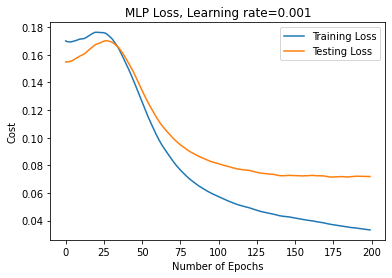

Accuracy of model 1: 0.9824561403508771


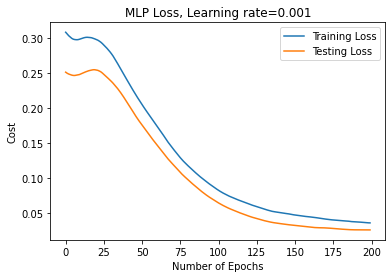

Accuracy of model 2: 0.956140350877193


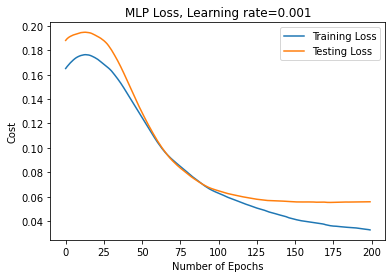

Accuracy of model 3: 0.9912280701754386


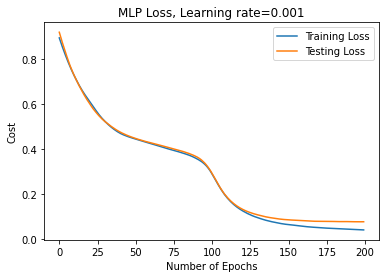

Accuracy of model 4: 0.9649122807017544


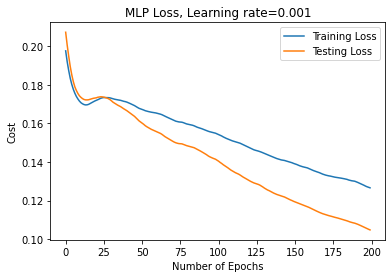

Accuracy of model 5: 1.0
0 models experienced overfitting
Hidden layer nodes=[5, 5] accuracy: 0.9789473684210526


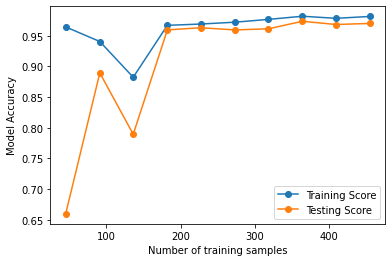

In [9]:
print("Testing hidden layer with nodes=[5, 5]")
hidden_layer_5_5 = five_fold_cross_validation([5, 5], INPUTS, TARGETS, light_verbose=True, plot_loss=True)
print("Hidden layer nodes=[5, 5] accuracy:", hidden_layer_5_5)
plot_learning_curve([5, 5], INPUTS, TARGETS)

Testing hidden layer with nodes=[10]


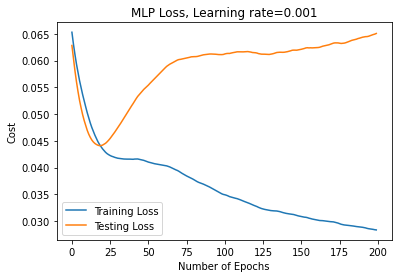

Accuracy of model 1: 0.9824561403508771


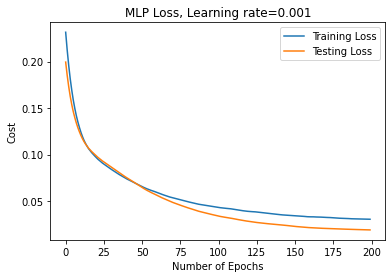

Accuracy of model 2: 0.9736842105263158


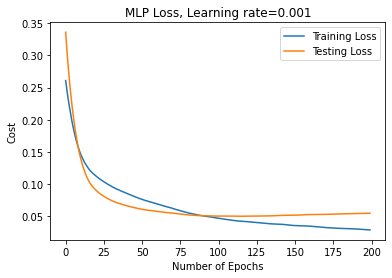

Accuracy of model 3: 0.9824561403508771


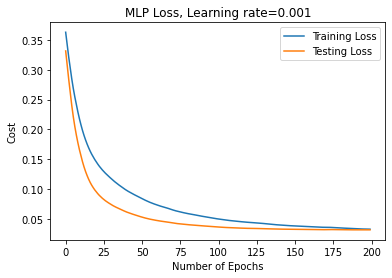

Accuracy of model 4: 0.9736842105263158


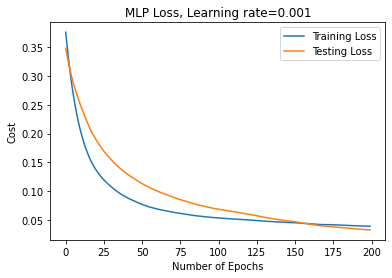

Accuracy of model 5: 1.0
1 model experienced overfitting
Hidden layer nodes=[10] accuracy: 0.9824561403508772


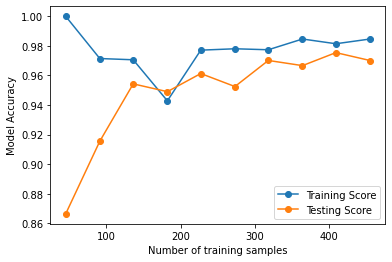

In [10]:
print("Testing hidden layer with nodes=[10]")
hidden_layer_10 = five_fold_cross_validation([10], INPUTS, TARGETS, light_verbose=True, plot_loss=True)
print("Hidden layer nodes=[10] accuracy:", hidden_layer_10)
plot_learning_curve([10], INPUTS, TARGETS)

Testing hidden layer with nodes=[10, 5]


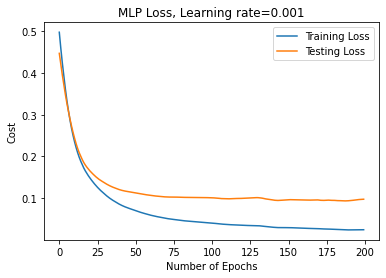

Accuracy of model 1: 0.956140350877193


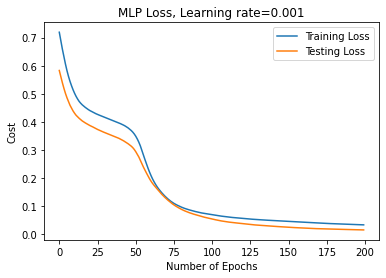

Accuracy of model 2: 0.9912280701754386


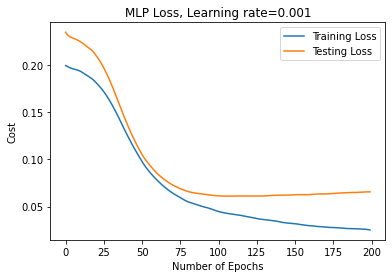

Accuracy of model 3: 0.9912280701754386


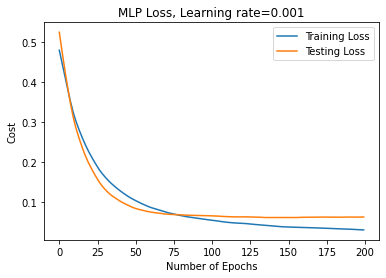

Accuracy of model 4: 0.956140350877193


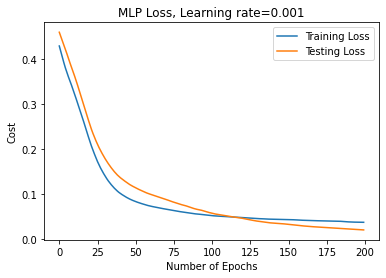

Accuracy of model 5: 1.0
0 models experienced overfitting
Hidden layer nodes=[10, 5] accuracy: 0.9789473684210528


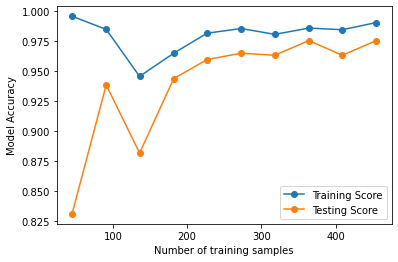

In [11]:
print("Testing hidden layer with nodes=[10, 5]")
hidden_layer_10_5 = five_fold_cross_validation([10, 5], INPUTS, TARGETS, light_verbose=True, plot_loss=True)
print("Hidden layer nodes=[10, 5] accuracy:", hidden_layer_10_5)
plot_learning_curve([10, 5], INPUTS, TARGETS)

Testing hidden layer with nodes=[5, 5, 5]


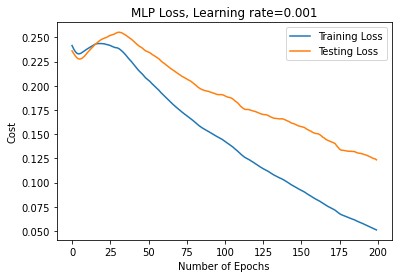

Accuracy of model 1: 0.9649122807017544


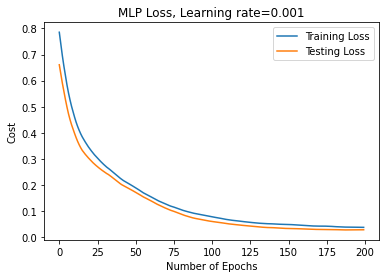

Accuracy of model 2: 0.9649122807017544


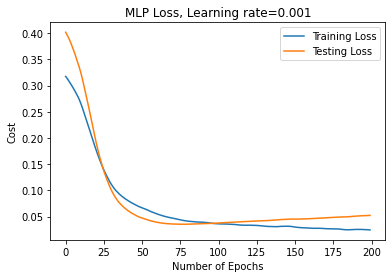

Accuracy of model 3: 0.9736842105263158


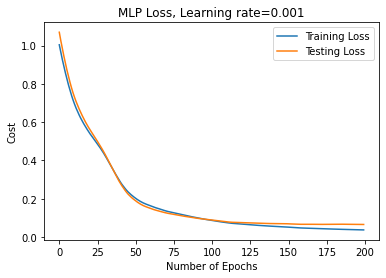

Accuracy of model 4: 0.9473684210526315


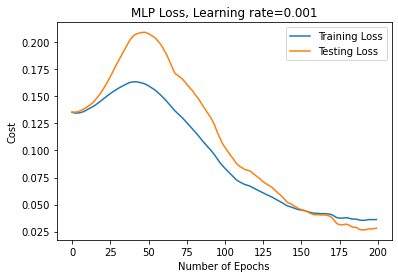

Accuracy of model 5: 0.9911504424778761
1 model experienced overfitting
Hidden layer nodes=[5, 5, 5] accuracy: 0.9684055270920664


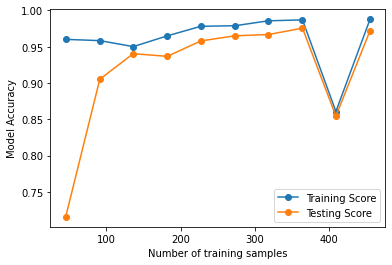

In [12]:
print("Testing hidden layer with nodes=[5, 5, 5]")
hidden_layer_5_5_5 = five_fold_cross_validation([5, 5, 5], INPUTS, TARGETS, light_verbose=True, plot_loss=True)
print("Hidden layer nodes=[5, 5, 5] accuracy:", hidden_layer_5_5_5)
plot_learning_curve([5, 5, 5], INPUTS, TARGETS)

Model Analysis:

The optimal network appears to be the network with simply 10 nodes in a single hidden layer. This network has the highest average accuracy as well as the lowest overfitting of models. This makes sense because this network is the least complex thus maximizing regularity and accuracy. Also, in the learning curve plot, the accuracies were highest when the amount of training data was the largest. This is ideal because the model should do the best when it has the most amount of data. <br><br>

One thing to mention: Every network tested in this project was tested with 200 epochs, and a learning rate of 0.001. Changing the number of epochs or changing the learning rate would also change the overfitting rate for models, because the more complex models might converge faster than these small models, and thus actually are quite successful. Because these values can be anything, it doesn't seem mearningful to change them becuase results could be manufactured by manipulating those values produce low overfitting. If a larger number of nodes were necessary, then these values would help with improving those models. For our purposes, they weren't necessary to work with.

# Conclusion
To conclude this project, I am going to do one last showcase of the network with 10 hidden layers. This was the optimal network, and it was able to accuratly predict diagnoses in this cancer dataset. In this final iteration I am going to print out the confusion matrix which shows the number of true postives, true negatives, false positives and false negatives produced by the prediction. To use this network to predict a diagnosis in a hospital, there would have to be a risk value assoiated with each prediciton. The confusion matrix would be helpful to analyze the predictions to see if the network favors one prediction over the other.<br><br>

Overall, since the optimal model is very accurate, the confusion matrix rarely has many wrong predictions.


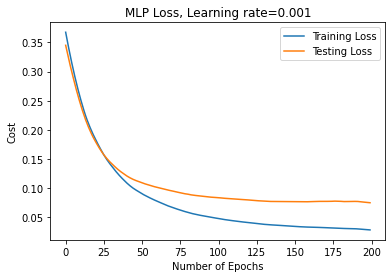

Accuracy of model 1: 0.9736842105263158
Confusion Matrix: [[74, 3],
                   [0, 37]]
Number of true benign predictions: 74
Number of false benign predictions: 3
Number of false malignant predictions: 0
Number of true malignant predictions: 37



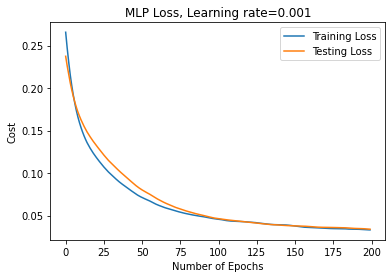

Accuracy of model 2: 0.9649122807017544
Confusion Matrix: [[73, 1],
                   [3, 37]]
Number of true benign predictions: 73
Number of false benign predictions: 1
Number of false malignant predictions: 3
Number of true malignant predictions: 37



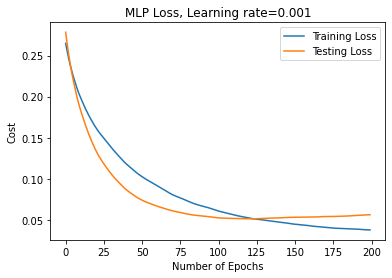

Accuracy of model 3: 0.9912280701754386
Confusion Matrix: [[64, 1],
                   [0, 49]]
Number of true benign predictions: 64
Number of false benign predictions: 1
Number of false malignant predictions: 0
Number of true malignant predictions: 49



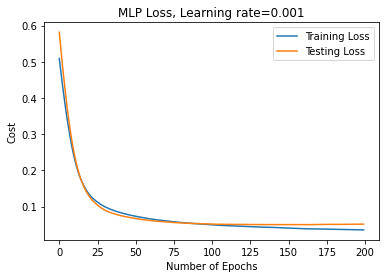

Accuracy of model 4: 0.9649122807017544
Confusion Matrix: [[71, 3],
                   [1, 39]]
Number of true benign predictions: 71
Number of false benign predictions: 3
Number of false malignant predictions: 1
Number of true malignant predictions: 39



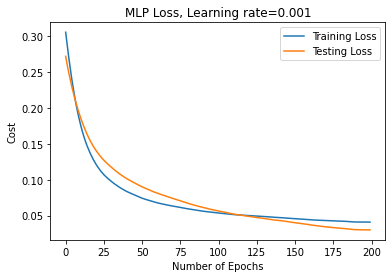

Accuracy of model 5: 0.9911504424778761
Confusion Matrix: [[71, 1],
                   [0, 41]]
Number of true benign predictions: 71
Number of false benign predictions: 1
Number of false malignant predictions: 0
Number of true malignant predictions: 41

0 models experienced overfitting
The accuracy of the optimal network is 0.9771774569166277


In [16]:
accuracy = five_fold_cross_validation([10], INPUTS, TARGETS, show_conf_matrix=True, plot_loss=True, light_verbose=True)
print(f"The accuracy of the optimal network is {accuracy}")

A better network may exist, but the one I found to be optimal is a simple single layer MLP with 10 nodes in the hidden layer. Rarely does this model overfit, and the accuracy is very high. In every test in the 5-fold cross-validation, the model also converges, so it is finding a seperator function. Thus, this model architecture is optimal.